In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np

import sys
import os

sys.path.append(os.environ['REPO_DIR'] + '/utilities')
from utilities2015 import *

import matplotlib.pyplot as plt
%matplotlib inline

from joblib import Parallel, delayed
import time

import logging

from registration_utilities import *

from collections import defaultdict

In [3]:
labels = ['BackG', '5N', '7n', '7N', '12N', 'Pn', 'VLL', 
          '6N', 'Amb', 'R', 'Tz', 'RtTg', 'LRt', 'LC', 'AP', 'sp5']

n_labels = len(labels)

labels_index = dict((j, i) for i, j in enumerate(labels))

labels_from_surround = dict( (l+'_surround', l) for l in labels[1:])

labels_surroundIncluded_list = labels[1:] + [l+'_surround' for l in labels[1:]]
labels_surroundIncluded = set(labels_surroundIncluded_list)

labels_surroundIncluded_index = dict((j, i) for i, j in enumerate(labels_surroundIncluded_list))

# colors = np.random.randint(0, 255, (len(labels_index), 3))
colors = np.loadtxt(os.environ['REPO_DIR'] + '/visualization/100colors.txt')
colors[labels_index['BackG']] = 1.

volume_dir = '/oasis/projects/nsf/csd395/yuncong/CSHL_volumes/'

volume1 = bp.unpack_ndarray_file(os.path.join(volume_dir, 'volume_MD589_annotation.bp'))

def parallel_where(l):
    w = np.where(volume1 == l)
    return np.array([w[1].astype(np.int16), w[0].astype(np.int16), w[2].astype(np.int16)]).T

t = time.time()

atlas_nzs = Parallel(n_jobs=16)(delayed(parallel_where)(l) for l in range(1, n_labels))

sys.stderr.write('load atlas: %f seconds\n' % (time.time() - t))

atlas_ydim, atlas_xdim, atlas_zdim = volume1.shape
atlas_centroid = (.5*atlas_xdim, .5*atlas_ydim, .5*atlas_zdim)
print atlas_centroid

atlas_vol_xmin, atlas_vol_xmax, atlas_vol_ymin, atlas_vol_ymax, atlas_vol_zmin, atlas_vol_zmax = \
np.loadtxt(os.path.join(volume_dir, 'volume_MD589_annotation_limits.txt'))


downsample_factor = 16

section_thickness = 20 # in um
xy_pixel_distance_lossless = 0.46
xy_pixel_distance_tb = xy_pixel_distance_lossless * 32 # in um, thumbnail
# factor = section_thickness/xy_pixel_distance_lossless

xy_pixel_distance_downsampled = xy_pixel_distance_lossless * downsample_factor
z_xy_ratio_downsampled = section_thickness / xy_pixel_distance_downsampled

from annotation_utilities import *
label_polygons = load_label_polygons_if_exists(stack='MD589', username='yuncong', force=False)

annotation_on_sections = get_annotation_on_sections(label_polygons=label_polygons, 
                                                    filtered_labels=labels_surroundIncluded)

landmark_range_limits = get_landmark_range_limits(stack='MD589', label_polygons=label_polygons, 
                                                  filtered_labels=labels_surroundIncluded)

landmark_zlimits = {l: [(int(z_xy_ratio_downsampled*e1) - atlas_vol_zmin, 
                         int(z_xy_ratio_downsampled*e2) -1 - atlas_vol_zmin) for e1, e2 in ranges] 
                    for l, ranges in landmark_range_limits.iteritems()}

landmark_zlimits_twoSides = {}
for l in range(1, n_labels):
    zlimits = landmark_zlimits[labels[l]]
    if len(zlimits) == 2:
        landmark_zlimits_twoSides[labels[l] + '_L'] = zlimits[0]
        landmark_zlimits_twoSides[labels[l] + '_R'] = zlimits[1]
    elif len(zlimits) == 1:
        landmark_zlimits_twoSides[labels[l]] = zlimits[0]
        
atlas_nzs_twoSides = {}
for name, (z_begin, z_end) in landmark_zlimits_twoSides.iteritems():
    
    if '_' in name:
        l = labels_index[name[:-2]]
    else:
        l = labels_index[name]
    
    nzs = atlas_nzs[l-1]
    atlas_nzs_twoSides[name] = nzs[(nzs[:,2] >= z_begin) & (nzs[:,2] <= z_end)]

(405.0, 202.5, 267.0)


load atlas: 1.523881 seconds


In [6]:
atlasAlignParams_rootdir = '/oasis/projects/nsf/csd395/yuncong/CSHL_atlasAlignParams'

In [61]:
# T_final = {}

parameters_allStacks_allLandmarks = defaultdict(dict)
atlas_centroid_allStacks_allLandmarks = defaultdict(dict)
test_centroid_allStacks_allLandmarks = defaultdict(dict)

for i, stack in enumerate(['MD585', 'MD590', 'MD594', 'MD593', 'MD592', 'MD591', 'MD595', 'MD602']):

#     with open(atlasAlignParams_rootdir + '/%(stack)s/%(stack)s_3dAlignParams.txt' % {'stack': stack}, 'r') as f:
#         lines = f.readlines()
#     T_final[stack] = np.array(map(float, lines[1].strip().split()))
    
    for name in atlas_nzs_twoSides.keys():

        with open(atlasAlignParams_rootdir + '/%(stack)s/%(stack)s_%(name)s_transformUponAffineProjection.txt' % \
                            {'stack': stack, 'name': name}, 'r') as f:
            lines = f.readlines()
            params = np.array(map(float, lines[0].strip().split()))
            atlas_centroid = np.array(map(float, lines[1].strip().split()))
            test_centroid = np.array(map(float, lines[2].strip().split()))

        parameters_allStacks_allLandmarks[stack][name] = params
        atlas_centroid_allStacks_allLandmarks[stack][name] = atlas_centroid
        test_centroid_allStacks_allLandmarks[stack][name] = test_centroid
        
parameters_allStacks_allLandmarks.default_factory = None
atlas_centroid_allStacks_allLandmarks.default_factory = None
test_centroid_allStacks_allLandmarks.default_factory = None

In [62]:
txs_allLandmarks = defaultdict(list)
tys_allLandmarks = defaultdict(list)
tzs_allLandmarks = defaultdict(list)

translations_allStack_allLandmarks = defaultdict(dict)

for stack, lm_tforms in parameters_allStacks_allLandmarks.iteritems():
    for name, T in lm_tforms.iteritems():
        Tm = np.reshape(T, (3,4))
        t = Tm[:, 3]
        R = Tm[:, :3]
        translations_allStack_allLandmarks[stack][name] = t
        
#         txs_allLandmarks[name].append(t[0])
#         tys_allLandmarks[name].append(t[1])
#         tzs_allLandmarks[name].append(t[2])
        
        txs_allLandmarks[name].append(t[0] * xy_pixel_distance_downsampled)
        tys_allLandmarks[name].append(t[1] * xy_pixel_distance_downsampled)
        tzs_allLandmarks[name].append(t[2] * xy_pixel_distance_downsampled)
    
translations_allStack_allLandmarks.default_factory = None

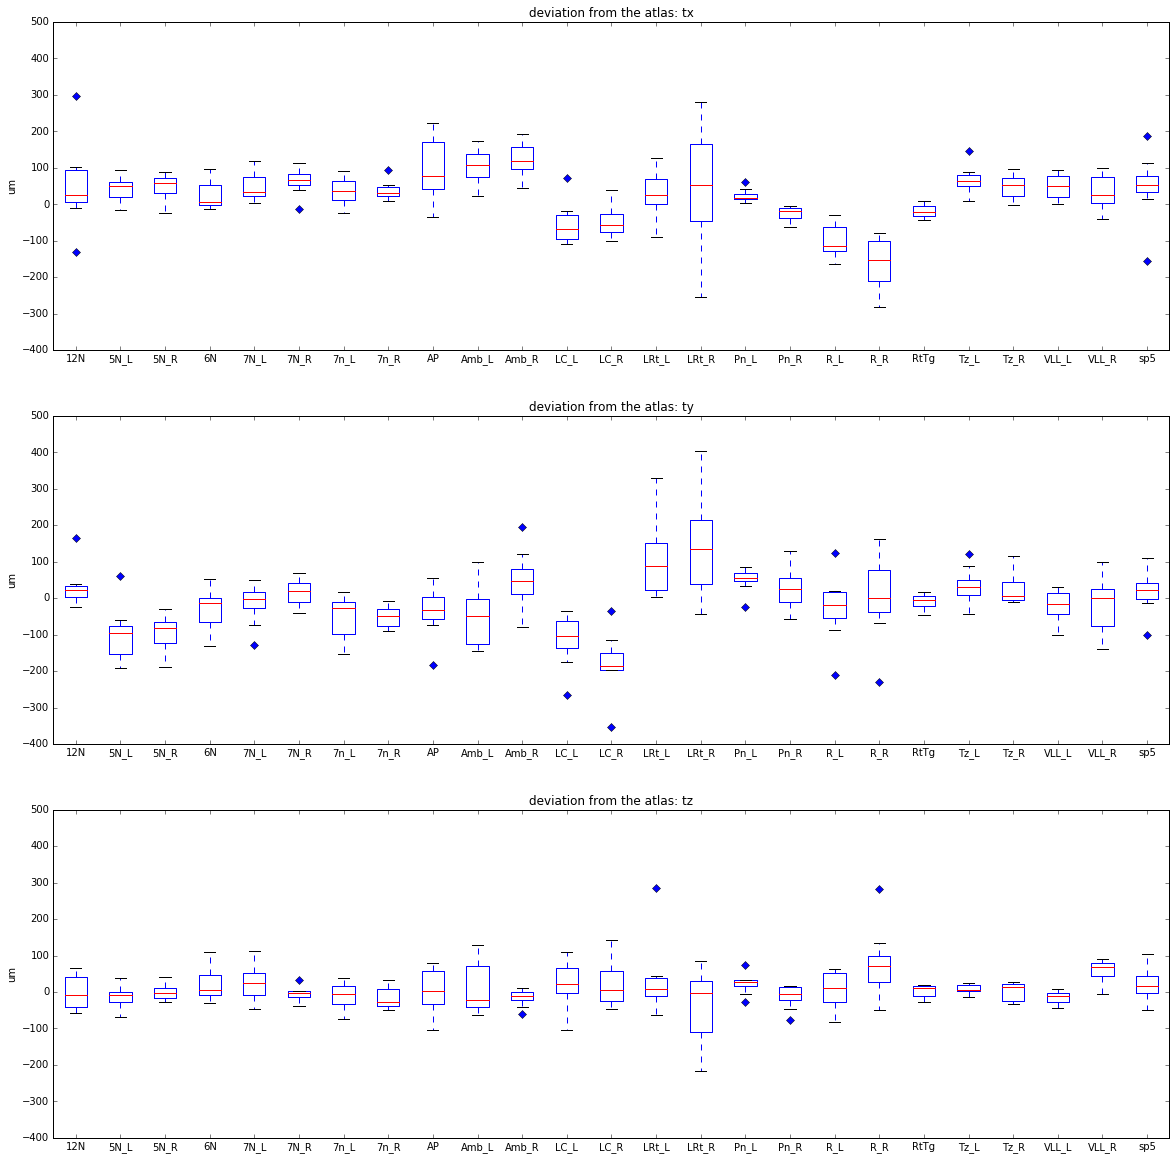

In [63]:
fig, axes = plt.subplots(3, 1, figsize=(20,20), squeeze=True, sharey=True)

for i, (d, v) in enumerate(zip([txs_allLandmarks, tys_allLandmarks, tzs_allLandmarks], ['tx', 'ty', 'tz'])):

    names = sorted(d.keys())
    data = np.array([d[name] for name in names]).T

    axes[i].boxplot(data, 0, 'gD');
#     axes[i].set_xticks(range(data.shape[1]), names);
    axes[i].set_ylabel('um');
    axes[i].set_title('deviation from the atlas: %s' % v)
    
plt.setp(axes, xticks=range(1, 1+data.shape[1]), xticklabels=names)
plt.show();